# Nash Value-Iteration
This tutorial  demonstrates Nash Value-Iteration on a zero-sum strategic (non-extensive) game. 

For the payoff matrix, row player is maximizer, coloumn player is minimizer.

Reference: 
* https://arxiv.org/abs/2006.12007
* http://proceedings.mlr.press/v139/liu21z.html

Status: TODO

## Get Arbitrary MDP Environment

Reward matrices: $[t, s, (a_1, a_2), s'] -> r$

Transition probability matrices: $[t, s, (a_1, a_2), s'] -> p$

In [2]:
import sys
sys.path.append("../..")
from mars.env.mdp import ArbitraryMDP, MDPWrapper
import numpy as np

num_states = 2
num_actions_per_player = 2
num_trans = 8

env = MDPWrapper(ArbitraryMDP(num_states=num_states, num_actions_per_player=num_actions_per_player, num_trans=num_trans))
trans_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]
reward_matrices = env.env.reward_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]

oracle_nash_v, oracle_nash_q, _ = env.NEsolver(verbose=False)
oracle_v_star = oracle_nash_v[0]

oracle_v_star = np.mean(oracle_v_star, axis=0)  # nash/best-response value of the first player from first-player's view
print(env.observation_space, env.action_space)
# # env.render()
# obs = env.reset()
# print(obs)
# done = False
# while not np.any(done):
#     obs, r, done, _ = env.step([1,0])
#     print(obs, r, done)
print('orcale v star: ', oracle_v_star)


Box(0.0, 18.0, (1,), float32) Discrete(2)
orcale v star:  0.08443882310669606


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


## Nash Value-Iteration

In [3]:
from mars.equilibrium_solver import NashEquilibriumECOSSolver, NashEquilibriumMWUSolver, NashEquilibriumParallelMWUSolver
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

def get_matrix(q_tab, state):
    return q_tab[state]

def get_nash_value(payoff, solver, solver_itr):
    if solver == 'ecos':
        ne, _ = NashEquilibriumECOSSolver(payoff)
        ne_value = ne[0]@payoff@ne[1].T
    elif solver == 'mwu':
        ne, ne_value = NashEquilibriumMWUSolver(payoff, Itr=solver_itr)
    else:
        raise NotImplementedError

    return ne_value

def get_random_action(dim):
    return np.random.randint(0, dim, size=2)

def get_action_from_nash(q_tab, state, solver, solver_itr):
    """ sample action from current 'nash' strategies. """
    payoff = get_matrix(q_tab, state)
    if solver == 'ecos':
        ne, _ = NashEquilibriumECOSSolver(payoff)
    elif solver == 'mwu':
        ne, ne_value = NashEquilibriumMWUSolver(payoff, Itr=solver_itr)
    else:
        raise NotImplementedError
        
    actions = []
    for dist in ne:
        sample_hist = np.random.multinomial(1, dist)
        a = np.where(sample_hist>0)
        actions.append(a[0][0])
    return actions

def compare_with_oracle(nash_q, oracle_nash_q):
    # nash_q_ = nash_q[:-num_states]  # no nash value for last-step states
    nash_q_ = nash_q
    nash_q_ = nash_q_.reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player)

    mse = np.mean((nash_q_ - np.array(oracle_nash_q))**2)
    return mse

def best_response_value(trans_prob_matrices, reward_matrices, learned_q, num_actions, debug=False):
    """
    Formulas for calculating best response values:
    1. Nash strategies: (\pi_a^*, \pi_b^*) = \min \max Q(s,a,b), 
        where Q(s,a,b) = r(s,a,b) + \gamma \min \max Q(s',a',b') (this is the definition of Nash Q-value);
    2. Best response (of max player) value: Br V(s) = \min_b \pi(s,a) Q(s,a,b)
    """

    Br_v = []
    Br_v1 = []
    Br_q = []
    Nash_strategies = []
    for tm, rm, qm in zip(trans_prob_matrices[::-1], reward_matrices[::-1], learned_q[::-1]): # inverse enumerate 
        if len(Br_v) > 0:
            rm = np.array(rm)+np.array(Br_v[-1])  # broadcast sum on rm's last dim, last one in Nash_v is for the next state
        br_q_values = np.einsum("ijk,ijk->ij", tm, rm)  # transition prob * reward for the last dimension in (state, action, next_state)
        br_q_values = br_q_values.reshape(-1, num_actions, num_actions) # action list to matrix
        Br_q.append(br_q_values)
        br_values = []
        br_values1 = []
        ne_strategies = []
        for q, br_q in zip(qm, br_q_values):
            ne, _ = NashEquilibriumECOSSolver(q)
            ne_strategies.append(ne)
            br_value = np.min(ne[0]@br_q)  # best response against "Nash" strategy of first player
            br_values.append(br_value)  # each value is a Nash equilibrium value on one state
            if debug:
                br_value1 = np.max(br_q@ne[1])  # best response against "Nash" strategy of second player
                br_values1.append(br_value1)  # each value is a Nash equilibrium value on one state
        Br_v.append(br_values)  # (trans, state)
        if debug:
            Br_v1.append(br_values1)
        Nash_strategies.append(ne_strategies)
    Br_v = Br_v[::-1]  # (#trans, #states)
    Br_v1 = Br_v1[::-1]
    Br_q = Br_q[::-1]
    Nash_strategies = Nash_strategies[::-1]

    avg_init_br_v = -np.mean(Br_v[0])  # average best response value of initial states; minus for changing the perspective from first to second player (exploiter)
    if debug:
        avg_init_br_v1 = -np.mean(Br_v1[0])
        print("if the two values equal, the Nash equilibrium calculation is accurate: ", avg_init_br_v, avg_init_br_v1)
    return avg_init_br_v

In [4]:
## evaluate the Nash solver
brv_oracle = best_response_value(env.env.trans_prob_matrices, env.env.reward_matrices, \
            np.array(oracle_nash_q).reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player), num_actions_per_player)

print(brv_oracle)

-0.08443882288934937


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


In [5]:
# anther a debug version:
# uniformly sample all states for the state visitation + do state transition estimate first
from mars.equilibrium_solver import NashEquilibriumECOSSolver, NashEquilibriumMWUSolver, NashEquilibriumParallelMWUSolver

def NEsolver(estimated_trans_prob_matrices, reward_matrices, num_actions, verbose = False):
    """
    Formulas for calculating Nash equilibrium strategies and values:
    1. Nash strategies: (\pi_a^*, \pi_b^*) = \min \max Q(s,a,b), 
        where Q(s,a,b) = r(s,a,b) + \gamma \min \max Q(s',a',b') (this is the definition of Nash Q-value);
    2. Nash value: Nash V(s) = \min \max Q(s,a,b) = \pi_a^* Q(s,a,b) \pi_b^{*T}
    """

    Nash_v = []
    Nash_q = []
    Nash_strategies = []
    for tm, rm in zip(estimated_trans_prob_matrices[::-1], reward_matrices[::-1]): # inverse enumerate 
        if len(Nash_v) > 0:
            rm = np.array(rm)+np.array(Nash_v[-1])  # broadcast sum on rm's last dim, last one in Nash_v is for the next state
        nash_q_values = np.einsum("ijk,ijk->ij", tm, rm)  # transition prob * reward for the last dimension in (state, action, next_state)
        nash_q_values = nash_q_values.reshape(-1, num_actions, num_actions) # action list to matrix
        Nash_q.append(nash_q_values)
        ne_values = []
        ne_strategies = []
        for nash_q_value in nash_q_values:
            ne, _ = NashEquilibriumECOSSolver(nash_q_value)
            ne_strategies.append(ne)
            ne_value = ne[0]@nash_q_value@ne[1].T
            ne_values.append(ne_value)  # each value is a Nash equilibrium value on one state
        Nash_v.append(ne_values)  # (trans, state)
        Nash_strategies.append(ne_strategies)
    Nash_v = Nash_v[::-1]
    Nash_q = Nash_q[::-1]
    Nash_strategies = Nash_strategies[::-1]  # (dim_transition, dim_state, #players, dim_action)
    if verbose:
        print('Nash values of all states (from start to end): \n', Nash_v)
        print('Nash Q-values of all states (from start to end): \n', Nash_q)
        print('Nash strategies of all states (from start to end): \n', Nash_strategies)

    return Nash_q

def nash_vi(env, gamma = 1, itr = 20000, epsilon = 0.5, update_interval = 200, solver='ecos', solver_itr=None):
    tau = np.sqrt(np.log(num_actions_per_player)/itr)

    # initialize Nash Q table 
    nash_q_tab = np.ones((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # there is (num_trans+1) state space
    print(nash_q_tab.shape)
    print(np.array(oracle_nash_q).shape)

    update_tab = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player)) # a buffer recording updates
    transition_entry_cnts = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player, num_states))  # counting the updates in each entry
    reward_tab = np.zeros((num_trans*num_states, num_actions_per_player, num_actions_per_player, num_states))

    mse_list = []
    brv_list = []
    all_itr = 0
    for i in range(itr):
        if i % 10 == 0:
            brv = best_response_value(env.env.trans_prob_matrices, env.env.reward_matrices, \
            nash_q_tab.reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player), num_actions_per_player)
            mse = compare_with_oracle(nash_q_tab, oracle_nash_q)
            mse_list.append(mse)
            brv_list.append(brv)
            print(f"process: {i/itr*100}%, mse: {mse}, brv: {brv}")

        obs = env.reset()
        done = False
        for curr_state in range(num_trans*num_states):
            for a1 in range(num_actions_per_player):
                for a2 in range(num_actions_per_player):
                    # if np.random.random() > epsilon:
                    #     action = get_action_from_nash(nash_q_tab, curr_state, solver, solver_itr)
                    # else:
                    #     action = get_random_action(num_actions_per_player)
                    action=  [a1, a2]
                    next_obs, r, done, _ = env.step(action, s=curr_state)

                    all_itr += 1

                    # acculmulate updates
                    next_state = next_obs[0][0] % num_states
                    transition_entry_cnts[curr_state, action[0], action[1], next_state] += 1
                    reward_tab[curr_state, action[0], action[1], next_state] = r[0]

                    obs = next_obs

        # update every loop over all states rather than according to update_interval
        transition_entry_probs = np.array(transition_entry_cnts/np.sum(transition_entry_cnts, axis=-1, keepdims=True))  # sum over next states
        transition_entry_probs = transition_entry_probs.reshape(num_trans, num_states, num_actions_per_player**2,  num_states)
        # nash_q_tab = NEsolver(transition_entry_probs, env.env.reward_matrices, num_actions_per_player)  # use oracle reward matrices
        reward_tab_ = np.array(reward_tab).reshape(num_trans, num_states, num_actions_per_player**2,  num_states)
        nash_q_tab = NEsolver(transition_entry_probs, reward_tab_, num_actions_per_player)  # use estimated reward matrices

        nash_q_tab = np.array(nash_q_tab)
    return mse_list, brv_list


(16, 2, 2)
(8, 2, 2, 2)
process: 0.0%, mse: 1.3831889427153832, brv: 1.1797039770887157


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


process: 0.5%, mse: 0.017187631259225362, brv: 0.20435547185248862
process: 1.0%, mse: 0.0033326236352690863, brv: 0.07126990520130272
process: 1.5%, mse: 0.002938612742979655, brv: 0.053358142309903586
process: 2.0%, mse: 0.002605973016867178, brv: 0.05492780552580494
process: 2.5%, mse: 0.001710940616163782, brv: 0.024746457813563646
process: 3.0%, mse: 0.0016345741154307853, brv: 0.013345669647566677
process: 3.5000000000000004%, mse: 0.0012339187433195913, brv: 0.003912358353345036
process: 4.0%, mse: 0.0025089837389656445, brv: -0.006811160679631278
process: 4.5%, mse: 0.0037554181671570646, brv: -0.01037510214151742
process: 5.0%, mse: 0.0051224183090952625, brv: -0.010239599520003341
process: 5.5%, mse: 0.007404311923427819, brv: -0.005167543846218486
process: 6.0%, mse: 0.005386556709085654, brv: -0.011266723312208753
process: 6.5%, mse: 0.00405045310921699, brv: -0.021993215641632397
process: 7.000000000000001%, mse: 0.004156205159245627, brv: -0.031875758586276726
process: 7.

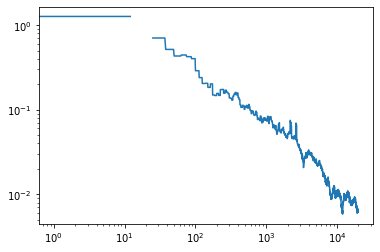

In [71]:
# mse_list, brv_list = nash_vi(env, itr=40000, epsilon = 1.0, solver='mwu', solver_itr=10)
mse_list, brv_list = nash_vi(env, itr=20000, epsilon = 1.0)

print(brv_list[-10:])
# plt.plot(mse_list, label='mse')
plt.plot(brv_list+oracle_v_star, label='brv')  # learned policy exploitability - optimal exploitability > 0 (from second player view)
plt.xscale('log')
plt.yscale('log')


## Large Env

In [6]:
import sys
sys.path.append("../..")
from mars.env.mdp import ArbitraryMDP, MDPWrapper
import numpy as np

num_states = 30
num_actions_per_player = 10
num_trans = 30

env = MDPWrapper(ArbitraryMDP(num_states=num_states, num_actions_per_player=num_actions_per_player, num_trans=num_trans))
trans_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]
reward_matrices = env.env.reward_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]

oracle_nash_v, oracle_nash_q, _ = env.NEsolver(verbose=False)
oracle_v_star = oracle_nash_v[0]

oracle_v_star = np.mean(oracle_v_star, axis=0)
print(env.observation_space, env.action_space)
print('orcale v star: ', oracle_v_star)

Box(0.0, 930.0, (1,), float32) Discrete(10)
orcale v star:  0.022837277086921827


(900, 10, 10)
(30, 30, 10, 10)
process: 0.0%, mse: 0.9947109245218864, brv: 1.74561801375632
process: 0.1%, mse: 0.03207139308928545, brv: 2.137287033750018
process: 0.2%, mse: 0.016310496440499193, brv: 1.8071239300073714
process: 0.3%, mse: 0.01067887635797707, brv: 1.6082626493992946
process: 0.4%, mse: 0.008441090872715884, brv: 1.4612357277834855
process: 0.5%, mse: 0.006438588156446229, brv: 1.3213322106323164
process: 0.6%, mse: 0.005532886295987133, brv: 1.2389596887546637
process: 0.7000000000000001%, mse: 0.004647950114336983, brv: 1.1800835441234947
process: 0.8%, mse: 0.0040080809493010594, brv: 1.094952909303055
process: 0.8999999999999999%, mse: 0.003566179259306124, brv: 1.0248707525136713
process: 1.0%, mse: 0.0031951471849984846, brv: 0.9958053794181679
process: 1.0999999999999999%, mse: 0.002906486777989566, brv: 0.9532903741555686
process: 1.2%, mse: 0.0026665308741518185, brv: 0.928691685665969
process: 1.3%, mse: 0.0024610014589477145, brv: 0.8879850311608991
proce

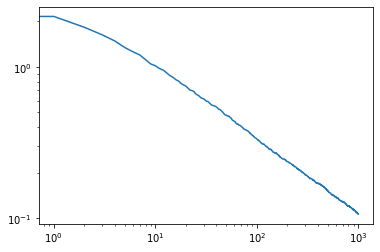

In [7]:
mse_list, brv_list = nash_vi(env, epsilon = 1.0, itr=10000)
plt.xscale('log')
plt.yscale('log')
plt.plot(np.array(brv_list)+oracle_v_star, label='brv')